In [1]:
import rtde_control
import rtde_receive
import os
import numpy as np
import time
import threading
import queue
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from ur_teleop.devices.magiclaw.phone import PhoneSubscriber

In [2]:
phone_subscriber = PhoneSubscriber(host="192.168.31.37", port=8000)
timestamp, _, _, _, _, _, phone_init_pose, velocity, rotation_rate = phone_subscriber.subscribeMessage()
print("Timestamp:", timestamp)
print("phone_init_pose:", phone_init_pose)
print("velocity:", velocity)
print("rotation_rate:", rotation_rate)

----------------------- Phone Subscriber Initialization ------------------------
Address: tcp://192.168.31.37:8000
Phone Subscriber Initialization Done.
--------------------------------------------------------------------------------
Timestamp: 1756891854.745212
phone_init_pose: [-0.0010800156742334366, 0.002880064770579338, 0.0018893443048000336, -0.01808767020702362, -0.00034122407669201493, 0.0023621320724487305, 0.9998335838317871]
velocity: [-1.5874726386755356e-06, 1.3904070328862872e-05, -0.0005066774319857359]
rotation_rate: [0.004294613376259804, 0.004001133143901825, -0.003400324145331979]


In [3]:
init_joint = np.array([-90.0, -60.0, -140.0, -70.0, -90.0, 0.0]) * np.pi / 180.0
rtde_c = rtde_control.RTDEControlInterface("192.168.31.10")
rtde_c.moveJ(init_joint.tolist(), 0.5, 1.0)
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.31.10")
initial_pose = np.array(rtde_r.getActualTCPPose())
initial_rot = R.from_rotvec(initial_pose[3:6])

In [10]:
def get_target_pose(initial_pose: np.ndarray, delta_trans: np.ndarray, delta_rot: R) -> np.ndarray:
    new_trans = initial_pose[:3] + delta_trans
    new_rot = delta_rot * R.from_rotvec(initial_pose[3:6])
    rotvec = new_rot.as_rotvec()
    
    return np.concatenate([new_trans, rotvec])

def get_delta_pose(initial_pose: np.ndarray, current_pose: np.ndarray) -> np.ndarray:
    initial_rot = R.from_rotvec(initial_pose[3:6])
    current_rot = R.from_rotvec(current_pose[3:6])
    delta_trans = current_pose[:3] - initial_pose[:3]
    delta_rot = current_rot * initial_rot.inv()
    
    return np.concatenate([delta_trans, delta_rot.as_rotvec()])

def convert_pose(pose: np.ndarray, conversion_matrix: np.ndarray) -> np.ndarray:
    """
    Convert a pose by applying a conversion matrix.

    Args:
        pose (np.ndarray): The pose to convert, expected to be a 7-element array (x, y, z, qx, qy, qz, qw).
        conversion_matrix (np.ndarray): The conversion matrix to apply.

    Returns:
        np.ndarray: The converted pose, which is also a 7-element array (x, y, z, qx, qy, qz, qw).
    """

    mat = np.eye(4, dtype=np.float32)
    mat[:3, :3] = R.from_quat(pose[3:]).as_matrix()
    mat[:3, 3] = pose[:3]

    converted_mat = conversion_matrix @ mat
    converted_pose = np.zeros_like(pose, dtype=np.float32)
    converted_pose[:3] = converted_mat[:3, 3]
    converted_pose[3:] = R.from_matrix(converted_mat[:3, :3]).as_quat()
    return converted_pose

def convert_speed(speed: np.ndarray, conversion_matrix: np.ndarray) -> np.ndarray:
    """
    Convert a speed vector by applying a conversion matrix.

    Args:
        speed (np.ndarray): The speed vector to convert, expected to be a 3-element array (vx, vy, vz).
        conversion_matrix (np.ndarray): The conversion matrix to apply.

    Returns:
        np.ndarray: The converted speed vector, which is also a 3-element array (vx, vy, vz).
    """

    converted_speed = conversion_matrix @ speed
    return converted_speed

def convert_rr(rotation_rate: np.ndarray, conversion_matrix: np.ndarray) -> np.ndarray:
    """
    Convert a rotation rate vector by applying a conversion matrix.

    Args:
        rotation_rate (np.ndarray): The rotation rate vector to convert, expected to be a 3-element array (wx, wy, wz).
        conversion_matrix (np.ndarray): The conversion matrix to apply.

    Returns:
        np.ndarray: The converted rotation rate vector, which is also a 3-element array (wx, wy, wz).
    """

    converted_rotation_rate = conversion_matrix @ rotation_rate
    return converted_rotation_rate

phone_pose_conv_mat = np.array(
    [
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
    ],
    dtype=np.float32,
)
phone_speed_conv_mat = np.array(
    [
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
    ],
    dtype=np.float32,
)
phone_rotation_rate_conv_mat = np.array(
    [
        [0, 0, 1],
        [0, -1, 0],  
        [1, 0, 0],
    ],
    dtype=np.float32,
)

In [ ]:
initial_pose = np.array(rtde_r.getActualTCPPose())

In [ ]:
rtde_c.moveJ(np.array([-90.0, -60.0, -140.0, -70.0, -90.0, 0.0]) * np.pi / 180.0, 0.5, 1.0)
initial_pose = np.array(rtde_r.getActualTCPPose())

In [ ]:
rtde_c.moveJ(np.array([-180.0, -60.0, -140.0, -70.0, -90.0, 90.0]) * np.pi / 180.0, 0.5, 1.0)
initial_pose = np.array(rtde_r.getActualTCPPose())

In [ ]:
rtde_c.moveL(get_target_pose(initial_pose, np.array([0.0, 0.0, 0.0]), R.from_euler('xyz', [0, 0, 0], degrees=True)).tolist(), 0.2, 1.0)
initial_pose = np.array(rtde_r.getActualTCPPose())

In [16]:
# Set target position (offset relative to initial position)
delta_pos = np.array([-0.2, 0.2, 0.1])
delta_rot = R.from_euler('xyz', [15, -15, 30], degrees=True)

initial_pose = np.array(rtde_r.getActualTCPPose())
_, _, _, _, _, _, phone_init_pose, _, _ = phone_subscriber.subscribeMessage()
phone_init_pose = convert_pose(phone_init_pose, phone_pose_conv_mat)
phone_init_rvec = R.from_quat(phone_init_pose[3:7]).as_rotvec()
phone_init_pose = [phone_init_pose[0], phone_init_pose[1], phone_init_pose[2], phone_init_rvec[0], phone_init_rvec[1], phone_init_rvec[2]]

target_pose = get_target_pose(initial_pose, delta_pos, delta_rot)
speed = 0.1
acceleration = 1.0

Starting dual-thread control...
Data collection thread started
Robot control thread started
Target position: [-0.33325362 -0.11823515  0.67623108  0.32272399 -0.185163    0.55464535]
Robot reached target position
Returning to initial position...
Robot reached target position
Returning to initial position...
Robot returned to initial position
Robot control thread ended
Data collection thread ended

Task completed! Collected 190 data points

=== Motion Data Analysis ===
Total data points: 190
Collection time: 6.29 seconds
Average sampling rate: 30.2 Hz

Position change range (mm):
  X-axis: -199.9 → 0.0 (change: 199.9)
  Y-axis: -0.0 → 200.0 (change: 200.0)
  Z-axis: -0.0 → 100.0 (change: 100.0)

Velocity statistics:
  Maximum linear velocity: 102.6 mm/s
  Average linear velocity: 94.7 mm/s
  Maximum angular velocity: 0.228 rad/s
  Average angular velocity: 0.210 rad/s
Robot returned to initial position
Robot control thread ended
Data collection thread ended

Task completed! Collected 19

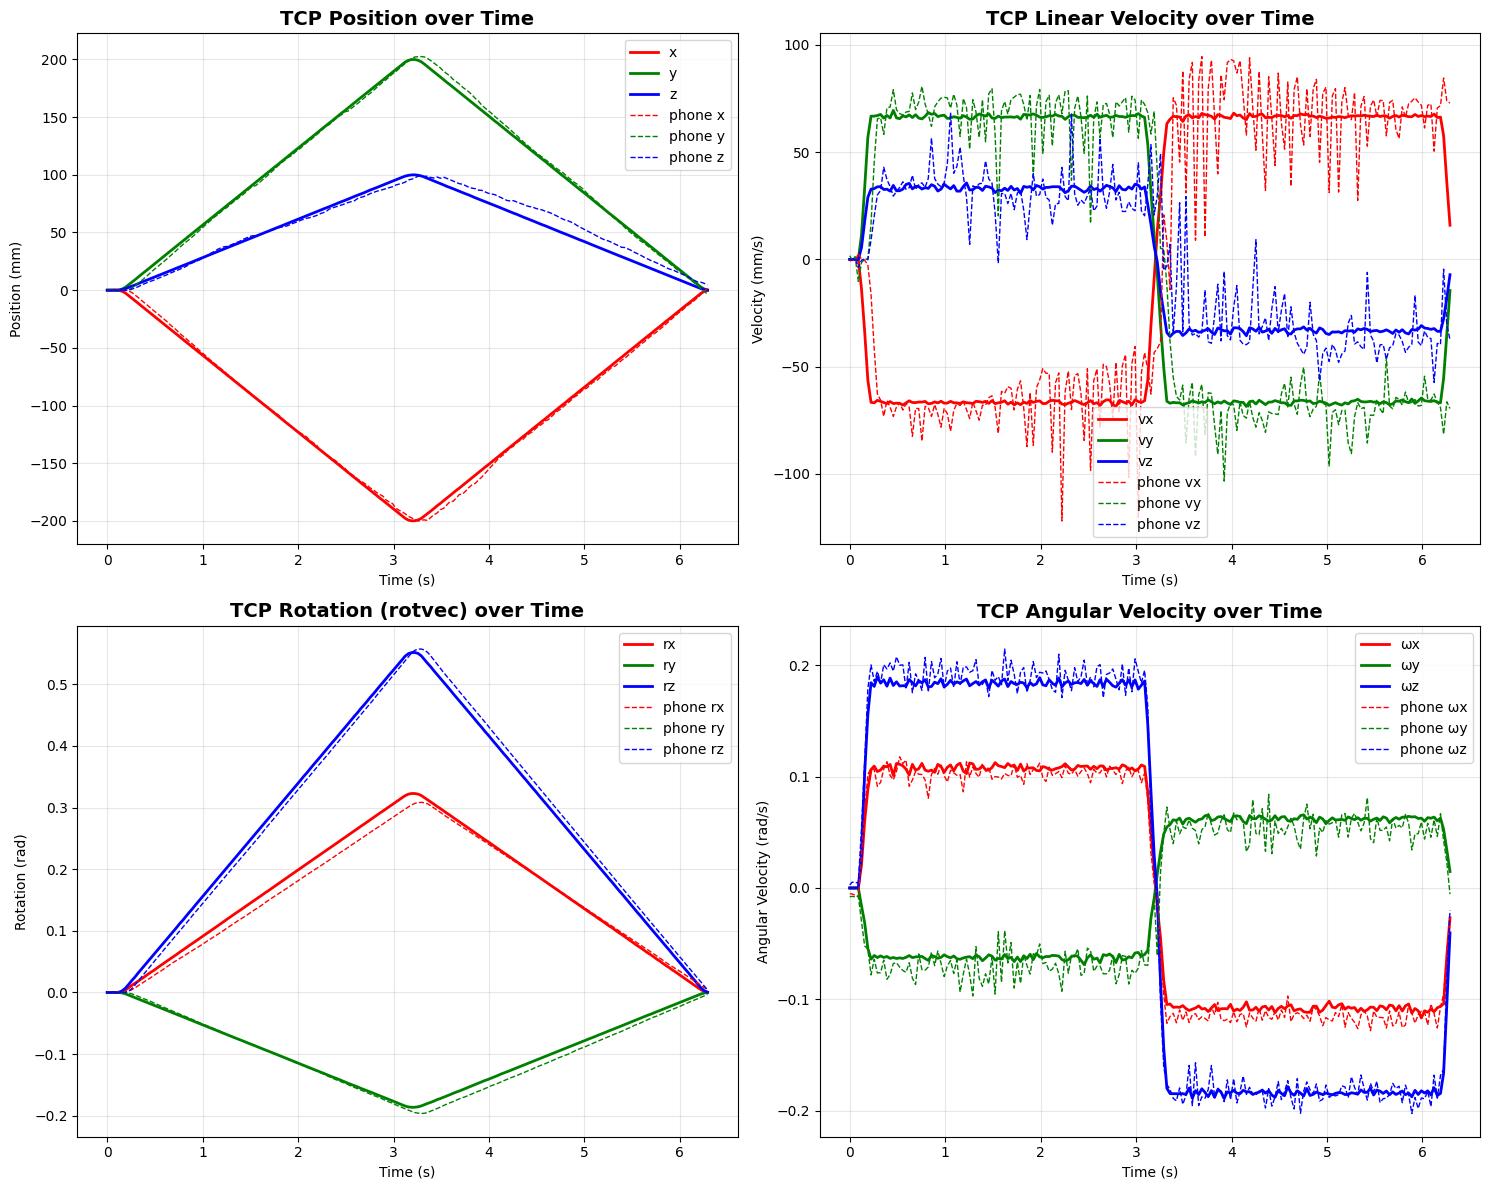

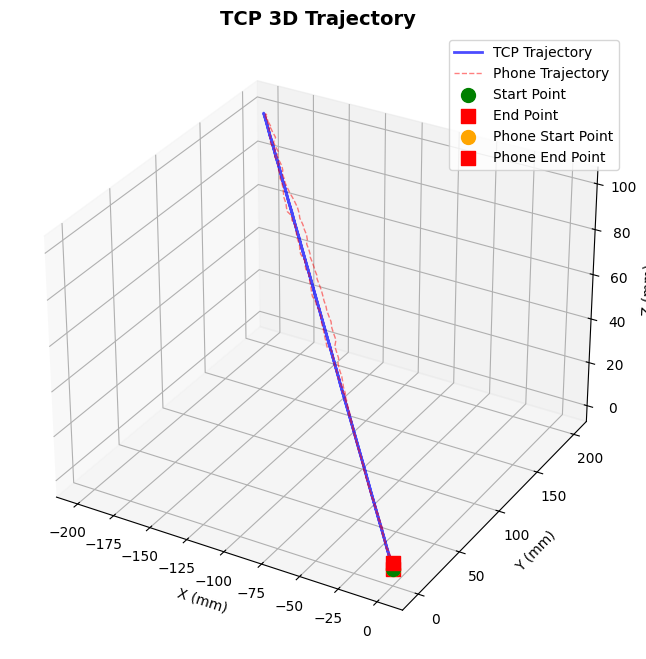

✅ Data saved to: data/phone_test/-200_200_100_15_-15_30_100_1000
📁 Contains files:
   📄 tcp_pose.txt - TCP pose data
   📄 tcp_speed.txt - TCP speed data
   📄 time.txt - timestamp data
   📄 phone_pose.txt - Phone pose data
   📄 phone_speed.txt - Phone speed data
   📄 motion_params.txt - motion parameters


In [17]:
# Data storage
pose_list = []
speed_list = []
time_list = []
phone_pose_list = []
phone_speed_list = []

initial_pose = np.array(rtde_r.getActualTCPPose())
_, _, _, _, _, _, phone_init_pose, _, _ = phone_subscriber.subscribeMessage()
phone_init_pose = convert_pose(phone_init_pose, phone_pose_conv_mat)
phone_init_rvec = R.from_quat(phone_init_pose[3:7]).as_rotvec()
phone_init_pose = [phone_init_pose[0], phone_init_pose[1], phone_init_pose[2], phone_init_rvec[0], phone_init_rvec[1], phone_init_rvec[2]]

# Control flag
data_collection_active = threading.Event()
data_collection_active.set()

# Thread 1: Data collection thread
def data_collection_thread():
    """Continuously read robot pose and speed data"""
    print("Data collection thread started")
    start_time = time.time()
    
    while data_collection_active.is_set():
        try:
            # Read current robot state
            current_pose = rtde_r.getActualTCPPose()
            current_speed = rtde_r.getActualTCPSpeed()
            current_time = time.time() - start_time
            
            _, _, _, _, _, _, phone_pose, phone_vel, phone_rr = phone_subscriber.subscribeMessage()
            phone_pose = convert_pose(phone_pose, phone_pose_conv_mat)
            phone_rvec = R.from_quat(phone_pose[3:7]).as_rotvec()
            phone_pose = [phone_pose[0], phone_pose[1], phone_pose[2], phone_rvec[0], phone_rvec[1], phone_rvec[2]]
            phone_vel = convert_speed(phone_vel, phone_speed_conv_mat)
            phone_rr = convert_rr(phone_rr, phone_rotation_rate_conv_mat)
            phone_speed = [phone_vel[0], phone_vel[1], phone_vel[2], phone_rr[0], phone_rr[1], phone_rr[2]]

            # Store data
            pose_list.append(get_delta_pose(initial_pose, np.array(current_pose)).tolist())
            speed_list.append(current_speed)
            time_list.append(current_time)
            phone_pose_list.append(get_delta_pose(phone_init_pose, np.array(phone_pose)).tolist())
            phone_speed_list.append(phone_speed)

            # Print status periodically
            if len(pose_list) % 200 == 0:
                print(f"Data points: {len(pose_list)}, Time: {current_time:.2f}s, "
                      f"Position: [{current_pose[0]:.3f}, {current_pose[1]:.3f}, {current_pose[2]:.3f}]")
            
            # Control sampling frequency (100Hz)
            time.sleep(0.02)
            
        except Exception as e:
            print(f"Data collection error: {e}")
            break
    
    print("Data collection thread ended")

# Thread 2: Robot control thread
def robot_control_thread():
    """Control robot movement"""
    print("Robot control thread started")
    print(f"Target position: {target_pose}")
    
    try:
        # Move to target position
        rtde_c.moveL(target_pose.tolist(), speed, acceleration)
        print("Robot reached target position")
        
        # Wait for a while to let data collection continue
        # time.sleep(1.0)
        
        # Return to initial position
        print("Returning to initial position...")
        rtde_c.moveL(initial_pose.tolist(), speed, acceleration)
        print("Robot returned to initial position")
        
    except Exception as e:
        print(f"Robot control error: {e}")
    finally:
        # Stop data collection
        data_collection_active.clear()
        print("Robot control thread ended")

# Clear previous data
pose_list.clear()
speed_list.clear()
time_list.clear()
phone_pose_list.clear()
phone_speed_list.clear()

# Create and start threads
print("Starting dual-thread control...")
data_thread = threading.Thread(target=data_collection_thread, daemon=True)
control_thread = threading.Thread(target=robot_control_thread, daemon=True)

# Start threads
data_thread.start()
time.sleep(0.1)  # Let data thread start first
control_thread.start()

# Wait for control thread to complete
try:
    control_thread.join()
    data_thread.join(timeout=2.0)  # Wait for data thread to end, max 2 seconds
except KeyboardInterrupt:
    print("\nUser interrupted")
    data_collection_active.clear()
    rtde_c.stopScript()

print(f"\nTask completed! Collected {len(pose_list)} data points")

if len(pose_list) > 0:
    data_dir = f"data/phone_test/{delta_pos[0]*1000:.0f}_{delta_pos[1]*1000:.0f}_{delta_pos[2]*1000:.0f}_{delta_rot.as_euler('xyz', degrees=True)[0]:.0f}_{delta_rot.as_euler('xyz', degrees=True)[1]:.0f}_{delta_rot.as_euler('xyz', degrees=True)[2]:.0f}_{speed*1000:.0f}_{acceleration*1000:.0f}"
    os.makedirs(data_dir, exist_ok=True)
    fig = plt.figure(figsize=(15, 12))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    # Display detailed statistics
    print(f"\n=== Motion Data Analysis ===")
    print(f"Total data points: {len(pose_list)}")
    print(f"Collection time: {time_list[-1]:.2f} seconds")
    print(f"Average sampling rate: {len(pose_list)/time_list[-1]:.1f} Hz")
    
    # Convert to numpy arrays
    pose_array = np.array(pose_list)
    speed_array = np.array(speed_list)
    time_array = np.array(time_list)
    phone_pose_array = np.array(phone_pose_list)
    phone_speed_array = np.array(phone_speed_list)

    print(f"\nPosition change range (mm):")
    print(f"  X-axis: {pose_array[:, 0].min()*1000:.1f} → {pose_array[:, 0].max()*1000:.1f} (change: {(pose_array[:, 0].max()-pose_array[:, 0].min())*1000:.1f})")
    print(f"  Y-axis: {pose_array[:, 1].min()*1000:.1f} → {pose_array[:, 1].max()*1000:.1f} (change: {(pose_array[:, 1].max()-pose_array[:, 1].min())*1000:.1f})")
    print(f"  Z-axis: {pose_array[:, 2].min()*1000:.1f} → {pose_array[:, 2].max()*1000:.1f} (change: {(pose_array[:, 2].max()-pose_array[:, 2].min())*1000:.1f})")
    
    print(f"\nVelocity statistics:")
    linear_speeds = np.linalg.norm(speed_array[:, :3], axis=1) * 1000
    angular_speeds = np.linalg.norm(speed_array[:, 3:], axis=1)
    print(f"  Maximum linear velocity: {linear_speeds.max():.1f} mm/s")
    print(f"  Average linear velocity: {linear_speeds.mean():.1f} mm/s")
    print(f"  Maximum angular velocity: {angular_speeds.max():.3f} rad/s")
    print(f"  Average angular velocity: {angular_speeds.mean():.3f} rad/s")
    
    # Plot TCP position over time (convert to mm)
    ax1.plot(time_array, pose_array[:, 0] * 1000, 'r-', label='x', linewidth=2)
    ax1.plot(time_array, pose_array[:, 1] * 1000, 'g-', label='y', linewidth=2)
    ax1.plot(time_array, pose_array[:, 2] * 1000, 'b-', label='z', linewidth=2)
    ax1.plot(time_array, phone_pose_array[:, 0] * 1000, 'r--', label='phone x', linewidth=1)
    ax1.plot(time_array, phone_pose_array[:, 1] * 1000, 'g--', label='phone y', linewidth=1)
    ax1.plot(time_array, phone_pose_array[:, 2] * 1000, 'b--', label='phone z', linewidth=1)
    ax1.set_title("TCP Position over Time", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Position (mm)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot TCP linear velocity over time (convert to mm/s)
    ax2.plot(time_array, speed_array[:, 0] * 1000, 'r-', label='vx', linewidth=2)
    ax2.plot(time_array, speed_array[:, 1] * 1000, 'g-', label='vy', linewidth=2)
    ax2.plot(time_array, speed_array[:, 2] * 1000, 'b-', label='vz', linewidth=2)
    ax2.plot(time_array, phone_speed_array[:, 0] * 1000, 'r--', label='phone vx', linewidth=1)
    ax2.plot(time_array, phone_speed_array[:, 1] * 1000, 'g--', label='phone vy', linewidth=1)
    ax2.plot(time_array, phone_speed_array[:, 2] * 1000, 'b--', label='phone vz', linewidth=1)
    ax2.set_title("TCP Linear Velocity over Time", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Velocity (mm/s)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot TCP rotation over time
    ax3.plot(time_array, pose_array[:, 3], 'r-', label='rx', linewidth=2)
    ax3.plot(time_array, pose_array[:, 4], 'g-', label='ry', linewidth=2)
    ax3.plot(time_array, pose_array[:, 5], 'b-', label='rz', linewidth=2)
    ax3.plot(time_array, phone_pose_array[:, 3], 'r--', label='phone rx', linewidth=1)
    ax3.plot(time_array, phone_pose_array[:, 4], 'g--', label='phone ry', linewidth=1)
    ax3.plot(time_array, phone_pose_array[:, 5], 'b--', label='phone rz', linewidth=1)
    ax3.set_title("TCP Rotation (rotvec) over Time", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Rotation (rad)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot TCP angular velocity over time
    ax4.plot(time_array, speed_array[:, 3], 'r-', label='ωx', linewidth=2)
    ax4.plot(time_array, speed_array[:, 4], 'g-', label='ωy', linewidth=2)
    ax4.plot(time_array, speed_array[:, 5], 'b-', label='ωz', linewidth=2)
    ax4.plot(time_array, phone_speed_array[:, 3], 'r--', label='phone ωx', linewidth=1)
    ax4.plot(time_array, phone_speed_array[:, 4], 'g--', label='phone ωy', linewidth=1)
    ax4.plot(time_array, phone_speed_array[:, 5], 'b--', label='phone ωz', linewidth=1)
    ax4.set_title("TCP Angular Velocity over Time", fontsize=14, fontweight='bold')
    ax4.set_xlabel("Time (s)")
    ax4.set_ylabel("Angular Velocity (rad/s)")
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig(os.path.join(data_dir, f"trajectory.png"), dpi=300)
    
    # Plot 3D trajectory
    fig_3d = plt.figure(figsize=(10, 8))
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    
    # Plot trajectory line
    ax_3d.plot(pose_array[:, 0] * 1000, pose_array[:, 1] * 1000, pose_array[:, 2] * 1000, 
               'b-', linewidth=2, alpha=0.7, label='TCP Trajectory')
    ax_3d.plot(phone_pose_array[:, 0] * 1000, phone_pose_array[:, 1] * 1000, phone_pose_array[:, 2] * 1000, 
               'r--', linewidth=1, alpha=0.5, label='Phone Trajectory')
    # Mark start and end points
    ax_3d.scatter(pose_array[0, 0] * 1000, pose_array[0, 1] * 1000, pose_array[0, 2] * 1000,
                  c='green', s=100, marker='o', label='Start Point')
    ax_3d.scatter(pose_array[-1, 0] * 1000, pose_array[-1, 1] * 1000, pose_array[-1, 2] * 1000,
                  c='red', s=100, marker='s', label='End Point')
    ax_3d.scatter(phone_pose_array[0, 0] * 1000, phone_pose_array[0, 1] * 1000, phone_pose_array[0, 2] * 1000,
                  c='orange', s=100, marker='o', label='Phone Start Point')
    ax_3d.scatter(phone_pose_array[-1, 0] * 1000, phone_pose_array[-1, 1] * 1000, phone_pose_array[-1, 2] * 1000,
                  c='red', s=100, marker='s', label='Phone End Point')
    ax_3d.set_xlabel('X (mm)')
    ax_3d.set_ylabel('Y (mm)')
    ax_3d.set_zlabel('Z (mm)')
    ax_3d.set_title('TCP 3D Trajectory', fontsize=14, fontweight='bold')
    ax_3d.legend()
    plt.show()
    
    # Convert to numpy arrays
    pose_array = np.array(pose_list)
    speed_array = np.array(speed_list) 
    time_array = np.array(time_list)
    
    # Save data files
    np.savetxt(f"{data_dir}/tcp_pose.txt", pose_array, 
               header="x(m) y(m) z(m) rx(rad) ry(rad) rz(rad)", 
               fmt="%.6f", delimiter='\t')
    
    np.savetxt(f"{data_dir}/tcp_speed.txt", speed_array,
               header="vx(m/s) vy(m/s) vz(m/s) wx(rad/s) wy(rad/s) wz(rad/s)",
               fmt="%.6f", delimiter='\t')
    
    np.savetxt(f"{data_dir}/time.txt", time_array,
               header="time(s)",
               fmt="%.6f")
    np.savetxt(f"{data_dir}/phone_pose.txt", phone_pose_array,
               header="x(m) y(m) z(m) rx(rad) ry(rad) rz(rad)",
               fmt="%.6f", delimiter='\t')
    np.savetxt(f"{data_dir}/phone_speed.txt", phone_speed_array,
               header="vx(m/s) vy(m/s) vz(m/s) wx(rad/s) wy(rad/s) wz(rad/s)",
               fmt="%.6f", delimiter='\t')
    
    # Save motion parameters
    with open(f"{data_dir}/motion_params.txt", 'w') as f:
        f.write(f"Initial Pose: {initial_pose}\n")
        f.write(f"Target Pose: {target_pose}\n") 
        f.write(f"Delta Position: {delta_pos}\n")
        f.write(f"Speed: {speed}m/s\n")
        f.write(f"Acceleration: {acceleration}m/s2\n")
        f.write(f"Total Time: {time_array[-1]:.3f}s\n")
        f.write(f"Data Points: {len(pose_list)}\n")
        f.write(f"Sampling Rate: {len(pose_list)/time_array[-1]:.1f}Hz\n")
    
    print(f"✅ Data saved to: {data_dir}")
    print(f"📁 Contains files:")
    print(f"   📄 tcp_pose.txt - TCP pose data")
    print(f"   📄 tcp_speed.txt - TCP speed data") 
    print(f"   📄 time.txt - timestamp data")
    print(f"   📄 phone_pose.txt - Phone pose data")
    print(f"   📄 phone_speed.txt - Phone speed data")
    print(f"   📄 motion_params.txt - motion parameters")

else:
    print("No data to display, please run the dual-thread control program first")

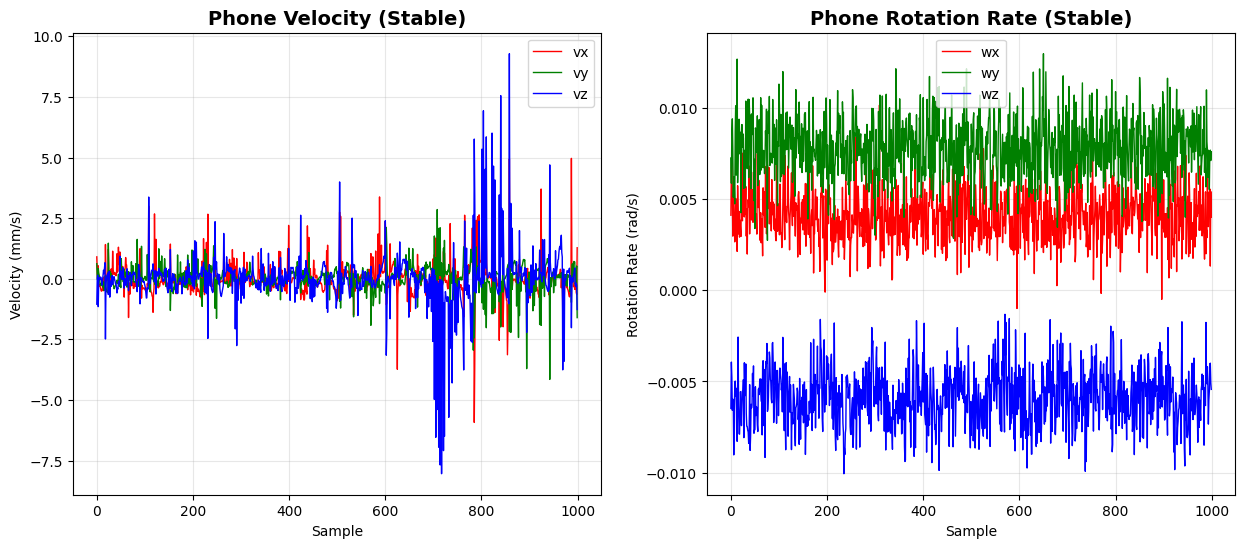

RTDEControlInterface: Could not receive data from robot...
RTDEControlInterface Exception: End of file
RTDEControlInterface: Robot is disconnected, reconnecting...
RTDEControlInterface Exception: Timeout connecting to UR dashboard server.
RTDEReceiveInterface boost system Exception: (asio.misc:2) End of file


Reconnecting...


In [23]:
vel_list = []
rotation_rate_list = []
for _ in range(1000):
    timestamp, _, _, _, _, _, phone_init_pose, velocity, rotation_rate = phone_subscriber.subscribeMessage()
    vel_list.append(velocity)
    rotation_rate_list.append(rotation_rate)
vel_list = np.array(vel_list)
rotation_rate_list = np.array(rotation_rate_list)

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
ax.set_xlabel("Sample")
ax.set_ylabel("Velocity (mm/s)")
ax.plot(vel_list[:, 0]*1000, 'r-', label='vx', linewidth=1)
ax.plot(vel_list[:, 1]*1000, 'g-', label='vy', linewidth=1)
ax.plot(vel_list[:, 2]*1000, 'b-', label='vz', linewidth=1)
ax.set_title("Phone Velocity (Stable)", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = fig.add_subplot(122)
ax.set_xlabel("Sample")
ax.set_ylabel("Rotation Rate (rad/s)")
ax.plot(rotation_rate_list[:, 0], 'r-', label='wx', linewidth=1)
ax.plot(rotation_rate_list[:, 1], 'g-', label='wy', linewidth=1)
ax.plot(rotation_rate_list[:, 2], 'b-', label='wz', linewidth=1)
ax.set_title("Phone Rotation Rate (Stable)", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)